In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import trange

In [2]:
# 解决缓存问题
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:
# 加载预训练 VGG 模型，要固定卷积核因此设置不可被训练
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
vgg.trainable = False

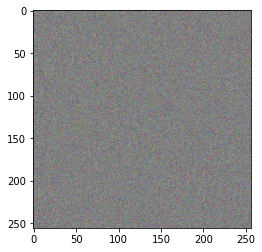

In [4]:
# 创建一张256*256的纯灰色图片，之后再叠加一个服从截断正态分布的噪声，并设置为可训练
input_img = tf.Variable(
    tf.ones(
        [1, 256, 256, 3]
    ) * 0.5 + tf.random.truncated_normal(
        [1, 256, 256, 3],
        mean=0.0,
        stddev=0.08
    )
    , trainable=True
)

plt.imshow(input_img.numpy()[0, ...])
plt.show()

In [5]:
# VGG 每个卷积层都有很多个 kernel，形成多通道。查看一下通道的个数
output1 = vgg.get_layer("block2_conv1").output
print(output1.shape)

output2 = vgg.get_layer("block5_conv4").output
print(output2.shape)

(None, None, None, 128)
(None, None, None, 512)


(1, 128, 128, 1)


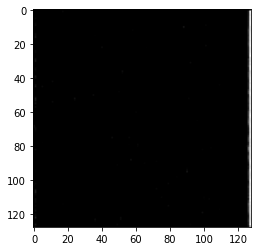

In [6]:
# 看一下 block2_conv1 的 101 号卷积核的输出
model1 = tf.keras.Model(vgg.input, output1[..., 100:101])
pic = model1(input_img)  # 把随机灰度图输入到模型
print(pic.shape)
plt.imshow(pic.numpy()[0, ..., 0], cmap='gray')
plt.show()

发现大多数输出是0（黑色），最右边一条白色，推测这个卷积核是用来检测边缘的。

In [7]:
# 优化图片：让loss最小，也就是让 tf.reduce_mean(model_output) 图片的均值最大，最大化输出的图片
optimizer = tf.keras.optimizers.RMSprop()

@tf.function()
def train_step1(image):
    with tf.GradientTape() as tape:
        model_output = model1(image)  # 前向传播
        loss = - tf.reduce_mean(model_output)
    grad = tape.gradient(loss, image)
    optimizer.apply_gradients([(grad, image)])
    return grad

  0%|                                                                                          | 0/300 [00:00<?, ?it/s]

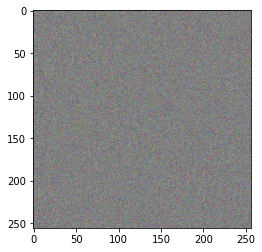

  0%|▎                                                                                 | 1/300 [00:00<02:37,  1.90it/s]

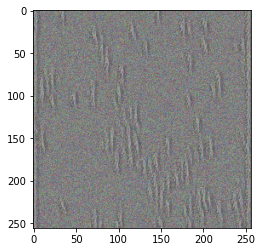

 17%|█████████████▊                                                                   | 51/300 [00:00<00:03, 75.04it/s]

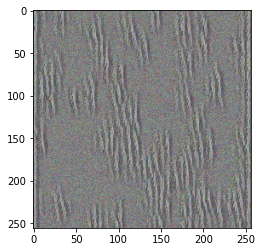

 34%|██████████████████████████▌                                                    | 101/300 [00:01<00:01, 109.15it/s]

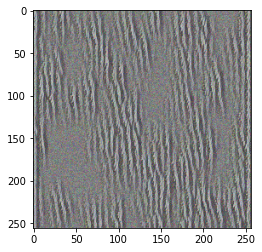

 50%|███████████████████████████████████████▊                                       | 151/300 [00:01<00:01, 127.26it/s]

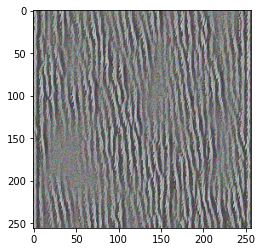

 67%|████████████████████████████████████████████████████▉                          | 201/300 [00:01<00:00, 138.35it/s]

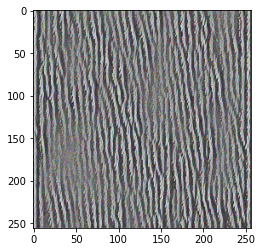

100%|███████████████████████████████████████████████████████████████████████████████| 300/300 [00:02<00:00, 142.40it/s]


In [8]:
for i in trange(300):
    
    if i%50 ==0:
        tf.clip_by_value(input_img, 0., 1.)  # 梯度下降后的像素值可能超出范围，截断到 [0, 1]

        plt.imshow(input_img.numpy()[0, ...])
        plt.show()
    
    grad = train_step1(input_img)
    '''if i%50 == 0:
        print(grad)'''

可以看到纯噪声图片经过训练后的结果，说明 block2_conv1 的 101 号卷积核可能在进行**竖直条纹的检测**。

同理，看一下 block5_conv5 的 85 号卷积核的输出：

(1, 16, 16, 1)


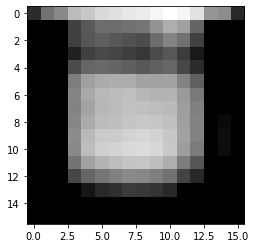

In [9]:
input_img2 = tf.Variable(
    tf.ones(
        [1, 256, 256, 3]
    ) * 0.5 + tf.random.truncated_normal(
        [1, 256, 256, 3],
        mean=0.0,
        stddev=0.08
    )
    , trainable=True
)

output2 = vgg.get_layer("block5_conv4").output

model2 = tf.keras.Model(vgg.input, output2[..., 84:85])
pic = model2(input_img2)  # 把随机灰度图输入到模型
print(pic.shape)
plt.imshow(pic.numpy()[0, ..., 0], cmap='gray')
plt.show()

高层的卷积核，看上去在进行一些高层次的认知。

  0%|                                                                                          | 0/300 [00:00<?, ?it/s]

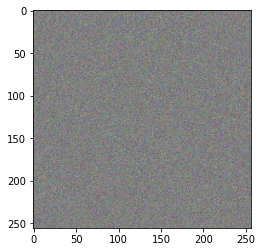

 15%|████████████▏                                                                    | 45/300 [00:01<00:05, 44.00it/s]

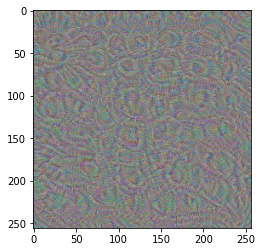

 30%|████████████████████████▌                                                        | 91/300 [00:02<00:04, 46.96it/s]

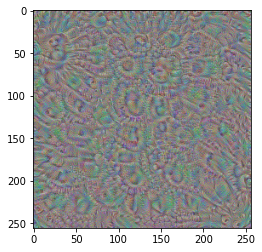

 47%|█████████████████████████████████████▊                                          | 142/300 [00:03<00:03, 48.52it/s]

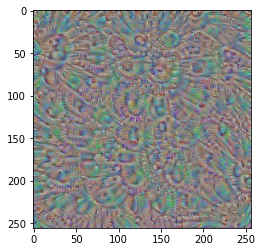

 64%|███████████████████████████████████████████████████▏                            | 192/300 [00:04<00:02, 48.30it/s]

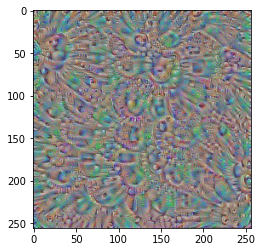

 80%|████████████████████████████████████████████████████████████████▎               | 241/300 [00:05<00:01, 49.28it/s]

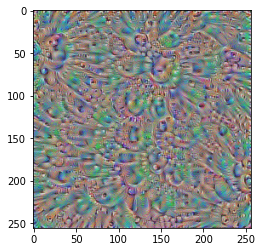

100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:07<00:00, 40.91it/s]


In [10]:
optimizer = tf.keras.optimizers.RMSprop()

@tf.function()
def train_step2(image):
    with tf.GradientTape() as tape:
        model_output = model2(image)  # 前向传播
        loss = - tf.reduce_mean(model_output)
    grad = tape.gradient(loss, image)
    optimizer.apply_gradients([(grad, image)])
    return grad


for i in trange(300):   
    if i%50 ==0:
        tf.clip_by_value(input_img2, 0., 1.)  # 梯度下降后的像素值可能超出范围，截断到 [0, 1]

        plt.imshow(input_img2.numpy()[0, ...])
        plt.show()
    
    grad = train_step2(input_img2)
    '''if i%50 == 0:
        print(grad)'''

- 浅层卷积核，提取的特征简单、具体
- 深层卷积核，提取的特征复杂、抽象